# Model Training

## Model

In [23]:
import os
import string  # Import the string module for alphabet letters
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
input_shape = (256, 256, 1)  # Adjust based on your preprocessed image dimensions

# Function to build the CNN model
def build_cnn_model(num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Function to compile the model
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Function to apply data augmentation
def apply_data_augmentation(train_dir):
    # Extract alphabet letters
    alphabet_letters = string.ascii_uppercase
    classes = [folder for folder in os.listdir(train_dir) if folder.upper() in alphabet_letters]

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return train_datagen.flow_from_directory(
        train_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical',
        classes=classes
    )

# Function to train the model
def train_model(model, train_generator, epochs=10):
    model.fit(train_generator, epochs=epochs)

# Function to evaluate the model
def evaluate_model(model, test_generator):
    return model.evaluate(test_generator)

# Specify the path to the preprocessed training images
preprocessed_train_images_folder_path = '/Users/aditya/Desktop/Class/DS675Machine Learning/Project/DATASET/SPLIT/train'

# Apply data augmentation
train_generator = apply_data_augmentation(preprocessed_train_images_folder_path)

# Build the CNN model
cnn_model = build_cnn_model(num_classes=len(train_generator.class_indices))

# Compile the model
compile_model(cnn_model)

# Train the model
train_model(cnn_model, train_generator, epochs=13)

# Specify the path to the test images
test_dataset_folder_path = '/Users/aditya/Desktop/Class/DS675Machine Learning/Project/DATASET/SPLIT/test'

# Apply data augmentation to the test set
test_generator = apply_data_augmentation(test_dataset_folder_path)

# Evaluate the model on the test set
evaluation_result = evaluate_model(cnn_model, test_generator)
print("Evaluation Result:", evaluation_result)


# Make predictions on the test set
predictions = cnn_model.predict(test_generator)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Loop through each prediction and print the class label with its probability
for i, prediction in enumerate(predictions):
    predicted_class_index = tf.argmax(prediction).numpy()
    predicted_class_label = class_labels[predicted_class_index]
    predicted_probability = prediction[predicted_class_index]

    print(f"Sample {i + 1}: Predicted Class - {predicted_class_label}, Probability - {predicted_probability:.4f}")

save_path  = '/Users/aditya/Desktop/Class/DS675Machine Learning/Project/DATASET/MODEL'
cnn_model.save(save_path)

Found 11524 images belonging to 17 classes.
Epoch 1/13
361/361 [==============================] - 437s 1s/step - loss: 2.5290 - accuracy: 0.1817
Epoch 2/13
361/361 [==============================] - 349s 965ms/step - loss: 1.9495 - accuracy: 0.3531
Epoch 3/13
361/361 [==============================] - 253s 702ms/step - loss: 1.5650 - accuracy: 0.4701
Epoch 4/13
361/361 [==============================] - 264s 730ms/step - loss: 1.3158 - accuracy: 0.5523
Epoch 5/13
361/361 [==============================] - 266s 737ms/step - loss: 1.1626 - accuracy: 0.5992
Epoch 6/13
361/361 [==============================] - 266s 737ms/step - loss: 1.0726 - accuracy: 0.6325
Epoch 7/13
361/361 [==============================] - 267s 738ms/step - loss: 0.9830 - accuracy: 0.6651
Epoch 8/13
361/361 [==============================] - 268s 741ms/step - loss: 0.9184 - accuracy: 0.6838
Epoch 9/13
361/361 [==============================] - 269s 746ms/step - loss: 0.8448 - accuracy: 0.7143
Epoch 10/13
361/361 [==

INFO:tensorflow:Assets written to: /Users/aditya/Desktop/Class/DS675Machine Learning/Project/DATASET/MODEL/assets


In [24]:
loaded_model = tf.keras.models.load_model(save_path)

## Prediction Functions

In [25]:
import cv2
import rembg
from PIL import Image
import numpy as np
import random
from IPython.display import Image as IPImage, display

# Function to capture an image from the default camera, remove the background, and preprocess it
def capture_and_preprocess():
    # Open the default camera (camera index 0)
    cap = cv2.VideoCapture(0)

    # Allow the camera to adjust (you may need to adjust the delay based on your camera)
    cv2.waitKey(1000)

    # Read a frame from the camera
    ret, frame = cap.read()

    # Release the camera capture
    cap.release()

    if ret:
        # Convert the OpenCV frame to a PIL Image
        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Use rembg to remove the background
        with rembg.remove(pil_image) as result:
            # Convert the result to an OpenCV format
            sign = cv2.cvtColor(np.array(result), cv2.COLOR_RGBA2BGRA)

        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(sign, cv2.COLOR_BGRA2GRAY)

        # Resize the image to the target size (256x256)
        target_size = (256, 256)
        resized_image = cv2.resize(grayscale_image, target_size)

        # Remove random noise (salt and pepper noise)
        noisy_image = Image.fromarray(resized_image)
        noisy_image = noisy_image.point(lambda p: p + random.choice([-50, 0, 50]) if random.random() < 0.05 else p)

        # Convert the noisy image back to NumPy array
        noisy_image_np = np.array(noisy_image)

        return frame, noisy_image_np
    else:
        print("Failed to capture an image.")
        return None

from gtts import gTTS
from IPython.display import Audio
from io import BytesIO

def text_to_speech(text):
    # Create a gTTS object with the desired text
    tts = gTTS(text=text, lang='en')

    # Save the generated speech to a BytesIO object
    audio_stream = BytesIO()
    tts.write_to_fp(audio_stream)
    audio_stream.seek(0)

    # Display the generated audio
    return Audio(data=audio_stream.read(), autoplay=True)





# Prediction

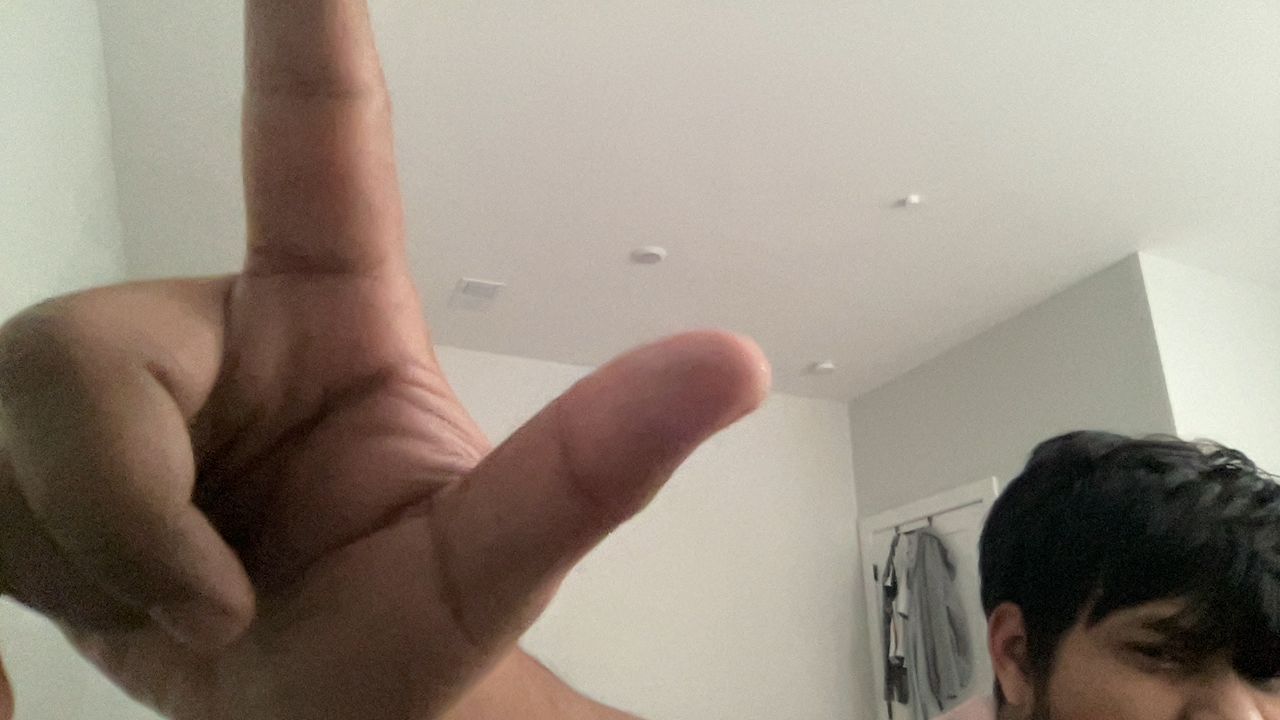

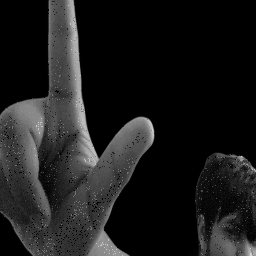

Image captured, background removed, and preprocessed.
1/1 [==============================] - 0s 124ms/step
Predicted Class - L, Probability - 1.0000
L


In [26]:
# Capture an image, remove the background, and preprocess it
input_image, preprocessed_image = capture_and_preprocess()

# Check if the preprocessed image was successfully captured
if preprocessed_image is not None:
    # Display the input image
    display(IPImage(data=cv2.imencode('.png', input_image)[1].tobytes(), format='png'))

    # Display the preprocessed image
    display(IPImage(data=cv2.imencode('.png', preprocessed_image)[1].tobytes(), format='png'))

    print("Image captured, background removed, and preprocessed.")
else:
    print("Image capture failed.")


# Assuming 'preprocessed_image' is your preprocessed image
input_array = np.expand_dims(preprocessed_image, axis=0)

# Make predictions on the input image
predictions = cnn_model.predict(input_array)

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Find the class label with the highest probability
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
predicted_probability = predictions[0, predicted_class_index]

# Print the predicted class label and its probability
print(f"Predicted Class - {predicted_class_label}, Probability - {predicted_probability:.4f}")


print(predicted_class_label)

text_input = predicted_class_label
audio_output = text_to_speech(text_input)

audio_output